In [3]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
from sklearn import svm

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
#import pymaster as nmt
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps
import decontaminate

In [4]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

#matplotlib.rc('text', usetex=True)
matplotlib.rc('text', usetex=False)

In [5]:
rng = default_rng(seed=42)

In [6]:
cmap_blues = utils.shiftedColorMap(matplotlib.cm.Blues, start=0.2, midpoint=0.6, stop=1.0)

In [8]:
cmap_greys = utils.shiftedColorMap(matplotlib.cm.Greys, start=0.2, midpoint=0.6, stop=1.0, name='Greys_shifted')

## Load quasar tables

In [9]:
#tab_gall_wnec = utils.get_table_with_necessary(tab_gall)
fn_gsup = '../data/gaia_candidates_superset.fits'
tab_gsup = utils.load_table(fn_gsup)
print(f"Number of Gaia quasar candidates with necessary data: {len(tab_gsup)}")

Number of Gaia quasar candidates with necessary data: 1518782


In [10]:
np.sum(tab_gsup['phot_g_mean_mag'] < 20.5)

1392662

## Load in labeled data

These are SDSS objects that have (any) Gaia source matches. There is unWISE data where available, but the below catalogs are not limited to unWISE matches.

In [9]:
tab_squasars = utils.load_table(f'../data/quasars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS quasars: {len(tab_squasars)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_squasars['mag_w1_vg']) & ~tab_squasars.mask['mag_w1_vg']))

Number of SDSS quasars: 379698
Number with unWISE info: 350070


In [10]:
tab_sstars = utils.load_table(f'../data/stars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS stars: {len(tab_sstars)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_sstars['mag_w1_vg']) & ~tab_sstars.mask['mag_w1_vg']))

Number of SDSS stars: 683221
Number with unWISE info: 482080


In [11]:
tab_sgals = utils.load_table(f'../data/galaxies_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS galaxies: {len(tab_sgals)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_sgals['mag_w1_vg']) & ~tab_sgals.mask['mag_w1_vg']))

Number of SDSS galaxies: 717059
Number with unWISE info: 600897


Only objects in superset (gaia qso candidates with unWISE data and QSOC redshifts and G lim)

In [67]:
fn_labeled_xsup = '../data/labeled_superset.fits'
tab_labeled_xsup = utils.load_table(fn_labeled_xsup)
print(f"Number of labeled Gaia quasar candidates for training/validation: {len(tab_labeled_xsup)}")

Number of labeled Gaia quasar candidates for training/validation: 249714


## Visualize samples

### Gaia quasar candidates wnec subset (has unWISE + Gaia redshifts)

1814201


Text(0, 0.5, '$W1-W2$')

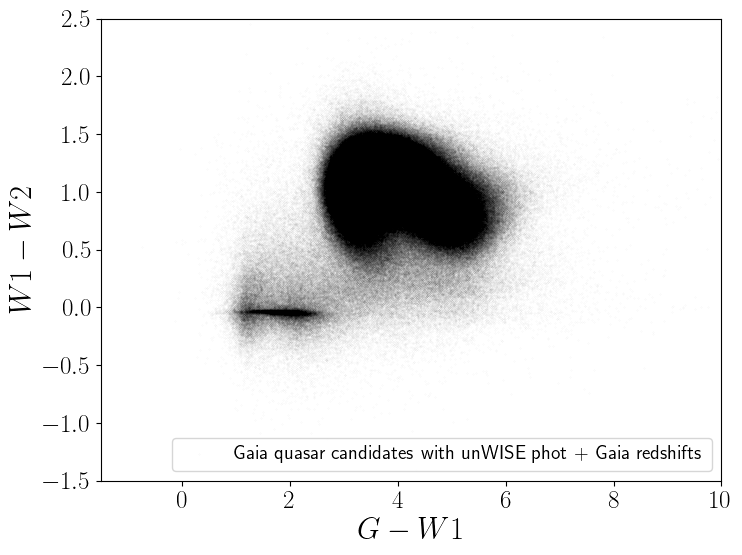

In [72]:
plt.figure(figsize=(8,6))
ax = plt.gca()

tabs = [tab_gwnec]
zorders = [2, 1, 0]

colors = ['black']
labels = ['Gaia quasar candidates with unWISE phot + Gaia redshifts']
ss = [0.05]

for i, tab in enumerate(tabs):
    print(len(tab))
    plt.scatter(tab['phot_g_mean_mag']-tab['mag_w1_vg'], tab['mag_w1_vg']-tab['mag_w2_vg'],
                color=colors[i], label=labels[i], alpha=0.05, s=ss[i], zorder=zorders[i])

plt.legend(loc='lower right', fontsize=(14))
plt.xlim(-1.5, 10)
plt.ylim(-1.5, 2.5)

plt.xlabel(r'$G-W1$')
plt.ylabel(r'$W1-W2$')

1518782


(-1.5, 2.5)

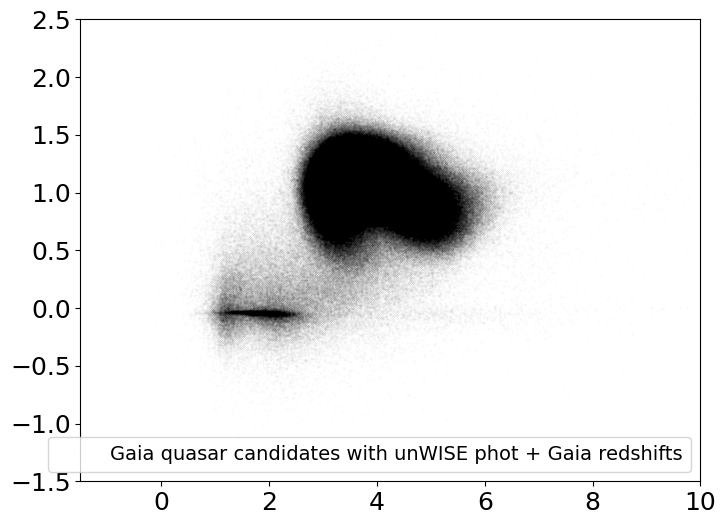

In [7]:
plt.figure(figsize=(8,6))
ax = plt.gca()

tabs = [tab_gsup]
zorders = [2, 1, 0]

colors = ['black']
labels = ['Gaia quasar candidates with unWISE phot + Gaia redshifts']
ss = [0.05]

for i, tab in enumerate(tabs):
    print(len(tab))
    plt.scatter(tab['phot_g_mean_mag']-tab['mag_w1_vg'], tab['mag_w1_vg']-tab['mag_w2_vg'],
                color=colors[i], label=labels[i], alpha=0.05, s=ss[i], zorder=zorders[i])

plt.legend(loc='lower right', fontsize=(14))
plt.xlim(-1.5, 10)
plt.ylim(-1.5, 2.5)

#plt.xlabel(r'$G-W1$')
#plt.ylabel(r'$W1-W2$')

Text(0, 0.5, '$W1-W2$')

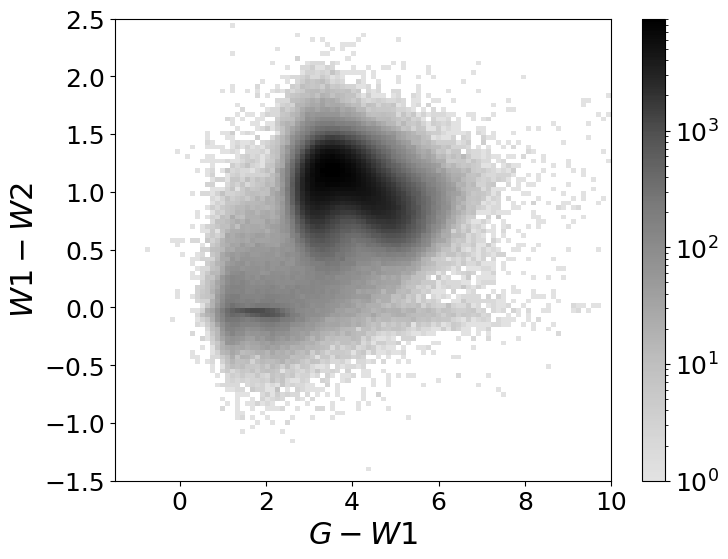

In [63]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

bins_x = np.linspace(-1.5, 10, 100)
bins_y = np.linspace(-1.5, 2.5, 100)

g_w1 = np.array(tab_gsup['phot_g_mean_mag']-tab_gsup['mag_w1_vg'])
w1_w2 = tab_gsup['mag_w1_vg']-tab_gsup['mag_w2_vg']
h = ax.hist2d(g_w1, w1_w2,
           bins=(bins_x, bins_y), cmin=1, cmap='Greys_shifted', norm='log')

fig.colorbar(h[3])

#plt.legend(loc='lower right', fontsize=(14))
plt.xlim(-1.5, 10)
ax.set_ylim(-1.5, 2.5)

plt.xlabel(r'$G-W1$')
plt.ylabel(r'$W1-W2$')

Text(0, 0.5, '$G-RP$')

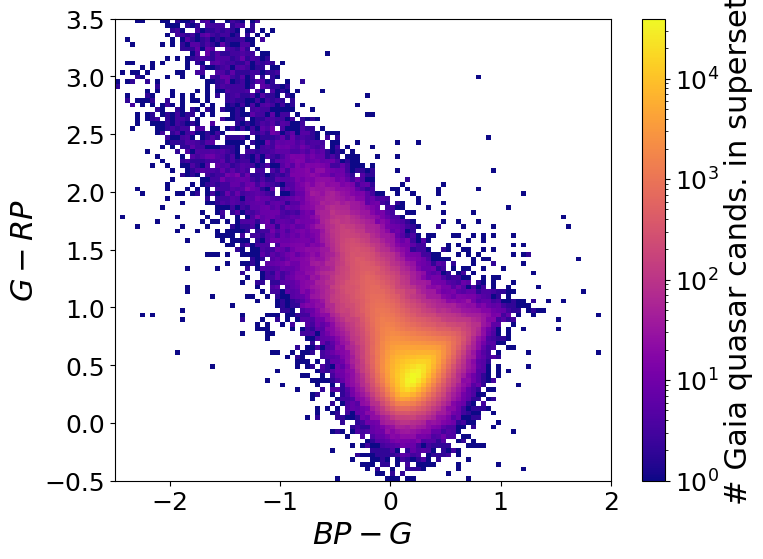

In [290]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

x_lim = (-2.5, 2)
y_lim = (-0.5, 3.5)
bins_x = np.linspace(*x_lim, 100)
bins_y = np.linspace(*y_lim, 100)

g_w1 = tab_gsup['phot_bp_mean_mag']-tab_gsup['phot_g_mean_mag']
w1_w2 = tab_gsup['phot_g_mean_mag']-tab_gsup['phot_rp_mean_mag']
h = ax.hist2d(g_w1, w1_w2,
           bins=(bins_x, bins_y), cmin=1, cmap='plasma', norm='log')

fig.colorbar(h[3], label='# Gaia quasar cands. in superset')

plt.xlim(x_lim)
plt.ylim(y_lim)

plt.xlabel(r'$BP-G$')
plt.ylabel(r'$G-RP$')

### All SDSS objects with all Gaia matches + unWISE data

379698
683221
717059


Text(0, 0.5, '$W1-W2$')

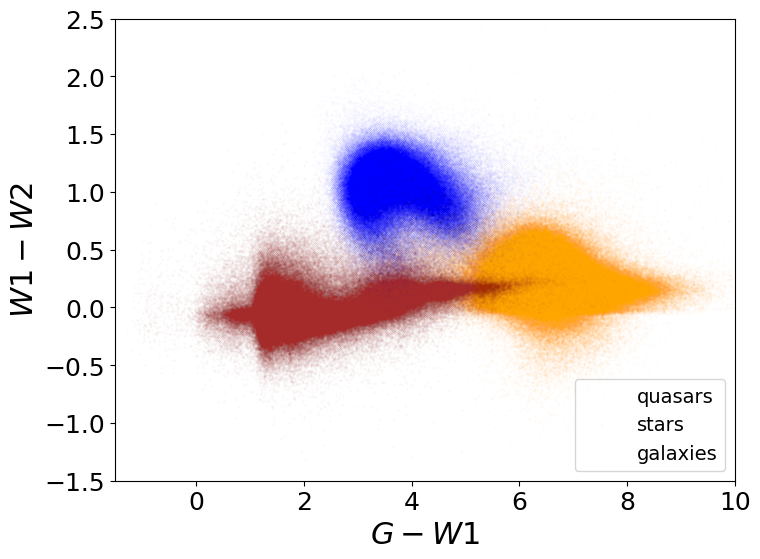

In [77]:
plt.figure(figsize=(8,6))
ax = plt.gca()

tabs = [tab_squasars, tab_sstars, tab_sgals]
zorders = [2, 1, 0]

colors = ['b', 'brown', 'orange', 'grey']
labels = ['quasars', 'stars', 'galaxies', 'gaia wnec']
ss = [0.01, 0.05, 0.05, 0.01]

for i, tab in enumerate(tabs):
    print(len(tab))
    plt.scatter(tab['phot_g_mean_mag']-tab['mag_w1_vg'], tab['mag_w1_vg']-tab['mag_w2_vg'],
                color=colors[i], label=labels[i], alpha=0.1, s=ss[i], zorder=zorders[i])

plt.legend(loc='lower right', fontsize=(14))
plt.xlim(-1.5, 10)
plt.ylim(-1.5, 2.5)

plt.xlabel(r'$G-W1$')
plt.ylabel(r'$W1-W2$')

### SDSS objects that are in Gaia quasar candidates catalog and have unWISE + Gaia redshifts

In [68]:
tab_q = tab_labeled_xsup[tab_labeled_xsup['class']=='q']
tab_s = tab_labeled_xsup[tab_labeled_xsup['class']=='s']
tab_g = tab_labeled_xsup[tab_labeled_xsup['class']=='g']
tabs = [tab_q, tab_s, tab_g]

zorders = [1,2,3,0]

colors = ['b', 'brown', 'orange', 'grey']
labels = ['quasars', 'stars', 'galaxies', 'gaia wnec']
ss = [0.1, 1, 1, 0.01]

295227
2374
2360


Text(0, 0.5, '$W1-W2$')

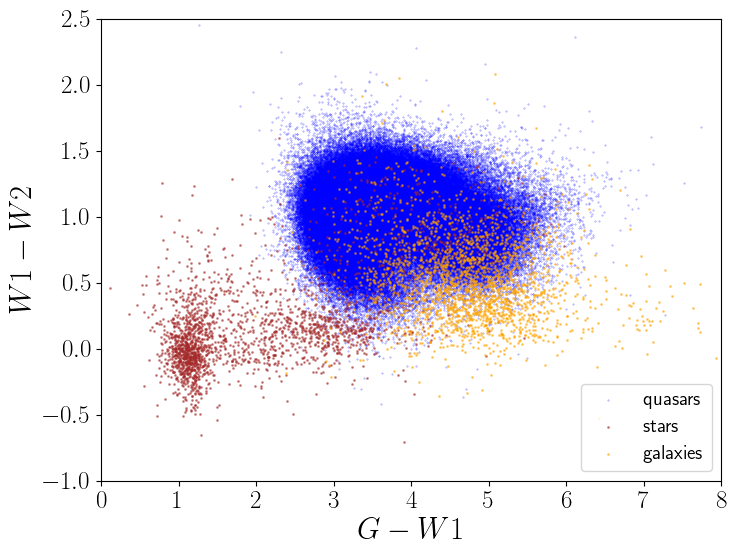

In [63]:
plt.figure(figsize=(8,6))
ax = plt.gca()

for i, tab in enumerate(tabs):
    print(len(tab))
    plt.scatter(tab['phot_g_mean_mag']-tab['mag_w1_vg'], tab['mag_w1_vg']-tab['mag_w2_vg'],
                color=colors[i], label=labels[i], alpha=0.5, s=ss[i], zorder=zorders[i])

plt.legend(loc='lower right', fontsize=(14))
plt.xlim(0, 8)
plt.ylim(-1, 2.5)

plt.xlabel(r'$G-W1$')
plt.ylabel(r'$W1-W2$')

Text(0, 0.5, '$W1-W2$')

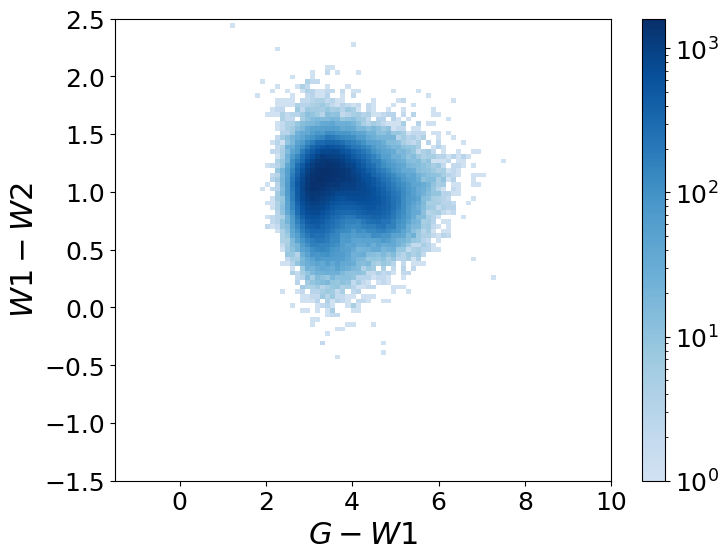

In [65]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

bins_x = np.linspace(-1.5, 10, 100)
bins_y = np.linspace(-1.5, 2.5, 100)

g_w1 = np.array(tab_q['phot_g_mean_mag']-tab_q['mag_w1_vg'])
w1_w2 = np.array(tab_q['mag_w1_vg']-tab_q['mag_w2_vg'])
h = ax.hist2d(g_w1, w1_w2,
           bins=(bins_x, bins_y), cmin=1, cmap='Blues_shifted',
             norm='log')

fig.colorbar(h[3])

#plt.legend(loc='lower right', fontsize=(14))
plt.xlim(-1.5, 10)
ax.set_ylim(-1.5, 2.5)

plt.xlabel(r'$G-W1$')
plt.ylabel(r'$W1-W2$')

Text(0, 0.5, '$G-RP$')

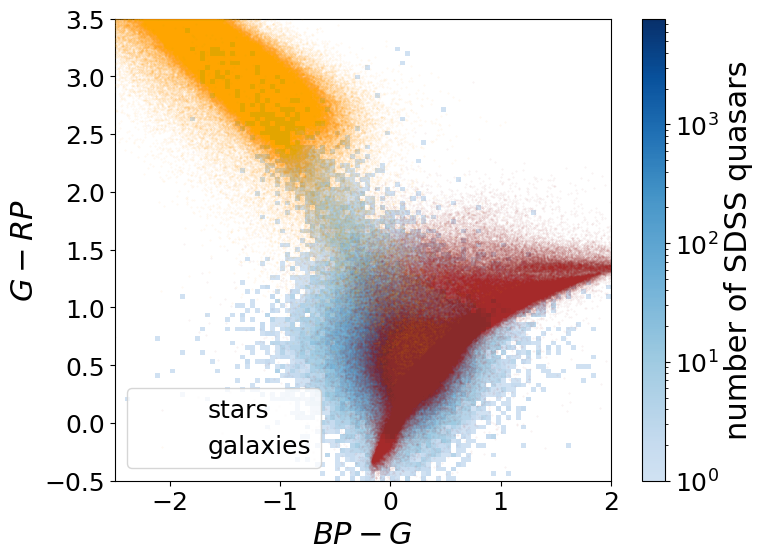

In [295]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()

x_lim = (-2.5, 2)
y_lim = (-0.5, 3.5)
bins_x = np.linspace(*x_lim, 100)
bins_y = np.linspace(*y_lim, 100)

g_w1 = tab_squasars['phot_bp_mean_mag']-tab_squasars['phot_g_mean_mag']
w1_w2 = tab_squasars['phot_g_mean_mag']-tab_squasars['phot_rp_mean_mag']
h = ax.hist2d(g_w1, w1_w2,
           bins=(bins_x, bins_y), cmin=1, cmap='Blues_shifted', norm='log')

tabs = [tab_squasars, tab_sstars, tab_sgals]
for i in range(1,len(tabs)):
    tab = tabs[i]
    plt.scatter(tab['phot_bp_mean_mag']-tab['phot_g_mean_mag'], 
                tab['phot_g_mean_mag']-tab['phot_rp_mean_mag'],
                color=colors[i], label=labels[i], alpha=0.1, s=0.1, zorder=zorders[i])

fig.colorbar(h[3], label='number of SDSS quasars')

plt.legend(loc='lower left')
plt.xlim(x_lim)
plt.ylim(y_lim)

plt.xlabel(r'$BP-G$')
plt.ylabel(r'$G-RP$')

## Get training test

In [14]:
def construct_X(tab):
    X = np.array([tab['phot_g_mean_mag']-tab['mag_w1_vg'],
                  tab['mag_w1_vg']-tab['mag_w2_vg']]).T
    return X

In [15]:
X_labeled = construct_X(tab_labeled_xsup)
i_train, i_valid, i_test = utils.split_train_val_test(tab_labeled_xsup['rand_ints'], 
                                                      frac_train=0.5, frac_test=0.25, frac_val=0.25)

X_train = X_labeled[i_train]
X_valid = X_labeled[i_valid]

#class_labels = ['q', 'o']
y_labeled = tab_labeled_xsup['class']
# y_labeled[y_labeled=='s'] = 'o'
# y_labeled[y_labeled=='g'] = 'o'

y_train = y_labeled[i_train]
y_valid = y_labeled[i_valid]

# Plot decontamination

In [16]:
def plot_cut(ax, cut, x_eq=None, y_eq=None, only_plot=None, only_axis=None):

    xx = np.array(ax.get_xlim())
    yy = np.array(ax.get_ylim())
    if only_plot=='above':
        if only_axis=='x':
            xx[0] = x_eq
        if only_axis=='y':
            yy[0] = y_eq
    if only_plot=='below':
        if only_axis=='x':
            xx[1] = x_eq
        if only_axis=='y':
            yy[1] = y_eq
            
    #ax.plot(xx, cut[0]*xx+cut[1], 'k-', lw=0.7)
    if abs(cut[0]) > abs(cut[1]):
        # solve ax+by=c for x: (c-by)/a
        xcut = (cut[2] - cut[1]*yy)/cut[0]
        ax.plot(xcut, yy, 'k-', lw=0.7)
    else:
        # solve ax+by=c for y: (c-ax)/b
        ycut = (cut[2] - cut[0]*xx)/cut[1]
        ax.plot(xx, ycut, 'k-', lw=0.7)

In [40]:
#fn_model = f'../data/decontamination_models/conf_mats_2lines_straight.npy'
#fn_model = f'../data/decontamination_models/conf_mats_2lines_straight_mag0.01.npy'
#fn_model = f'../data/decontamination_models/conf_mats_3lines_straight_mag0.1-0.01.npy'
    
tag_decontam = '_mag0.1_lg1'
fn_conf_mats = f'../data/decontamination_models/conf_mats{tag_decontam}.npy'
fn_cuts = f'../data/color_cuts{tag_decontam}.txt'

color_names, cuts = np.genfromtxt(fn_cuts, dtype=['U15', '<f8'], unpack=True)
results = np.load(fn_conf_mats, allow_pickle=True).item()

In [41]:
results = np.load(fn_conf_mats, allow_pickle=True).item()
color_names = results['color_names']
cut_arr = results['cut_min_arr']

class_labels = ['q', 's', 'g']
tps, fps_s, fps_g = decontaminate.get_metric_matrices(fn_conf_mats, class_labels)
objs = decontaminate.objective_function(tps, fps_s, fps_g)
indices_best = np.unravel_index(objs.argmax(), objs.shape)
N_colors = len(color_names)    

[11, 11, 11]


In [54]:
print(cuts)

[ 2.15  0.3  -0.5 ]


In [42]:
#g_w1_vals, w1_w2_vals, bp_g_vals = results['grid']
conf_mats = np.array(results['conf_mats'])
print(conf_mats.shape)

(11, 11, 11, 3, 3)


In [43]:
class_labels = ['q', 's', 'g']

In [44]:
# tps = np.empty((len(g_w1_vals),len(w1_w2_vals),len(bp_g_vals)))
# fps_s = np.empty((len(g_w1_vals),len(w1_w2_vals),len(bp_g_vals)))
# fps_g = np.empty((len(g_w1_vals),len(w1_w2_vals),len(bp_g_vals)))

# i_q = class_labels.index('q')
# i_s = class_labels.index('s')
# i_g = class_labels.index('g')

# for i in range(len(g_w1_vals)):
#     for j in range(len(w1_w2_vals)):
#         for k in range(len(bp_g_vals)):
#             conf_mat = conf_mats[i,j,k]
#             tps[i,j,k] = utils.N_TP(conf_mat, class_labels, label='q')        
#             fps_s[i,j,k] = conf_mat[i_s,i_q]        
#             fps_g[i,j,k] = conf_mat[i_g,i_q]

In [45]:
# lambda_s = 3
# lambda_g = 3
# objs = tps - lambda_s*fps_s - lambda_g*fps_g
# i_best, j_best, k_best = np.unravel_index(objs.argmax(), objs.shape)
# print(objs[i_best, j_best, k_best])
# print(g_w1_vals[i_best], w1_w2_vals[j_best], bp_g_vals[k_best])

In [46]:
g_w1_vals = cut_arr[color_names.index('g_w1')]
w1_w2_vals = cut_arr[color_names.index('w1_w2')]
bp_g_vals = cut_arr[color_names.index('bp_g')]

extent_left = [np.min(g_w1_vals), np.max(g_w1_vals), np.min(w1_w2_vals), np.max(w1_w2_vals)]
extent_right = [np.min(bp_g_vals), np.max(bp_g_vals), np.min(w1_w2_vals), np.max(w1_w2_vals)]
xlabel_left = 'G-W1 cut'
ylabel_left = 'W1-W2 cut'
xlabel_right = 'BP-G cut'
ylabel_right = 'W1-W2 cut'

In [47]:
i_best = indices_best[color_names.index('g_w1')]
j_best = indices_best[color_names.index('w1_w2')]
k_best = indices_best[color_names.index('bp_g')]

Text(0, 0.5, 'W1-W2 cut')

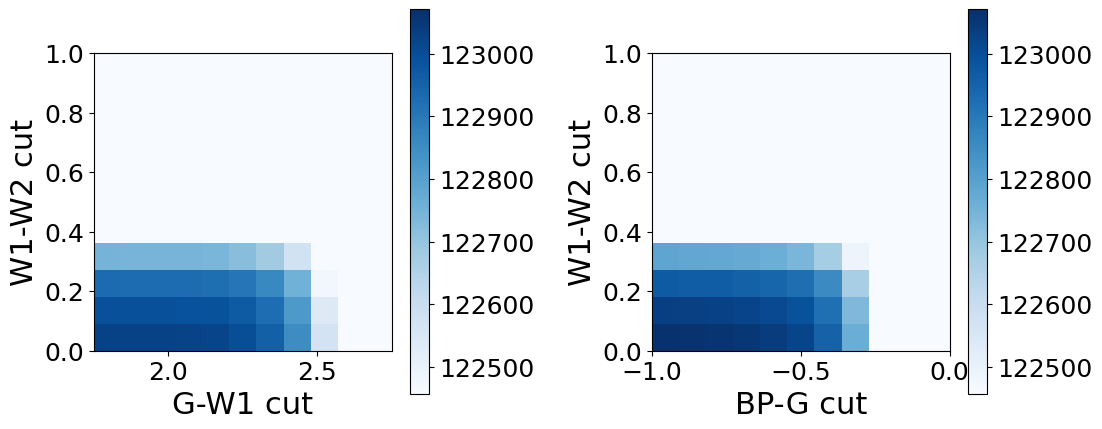

In [48]:
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)

plt.imshow(tps[:,:,k_best].T, cmap='Blues', origin='lower', extent=extent_left,
          vmin=0.995*np.max(tps), vmax=np.max(tps)
          )
plt.colorbar()
plt.xlabel(xlabel_left)
plt.ylabel(ylabel_left)

plt.subplot(122)
plt.imshow(tps[i_best,:,:], cmap='Blues', origin='lower', extent=extent_right,
          vmin=0.995*np.max(tps), vmax=np.max(tps)
          )
plt.colorbar()
plt.xlabel(xlabel_right)
plt.ylabel(ylabel_right)

Text(0, 0.5, 'W1-W2 cut')

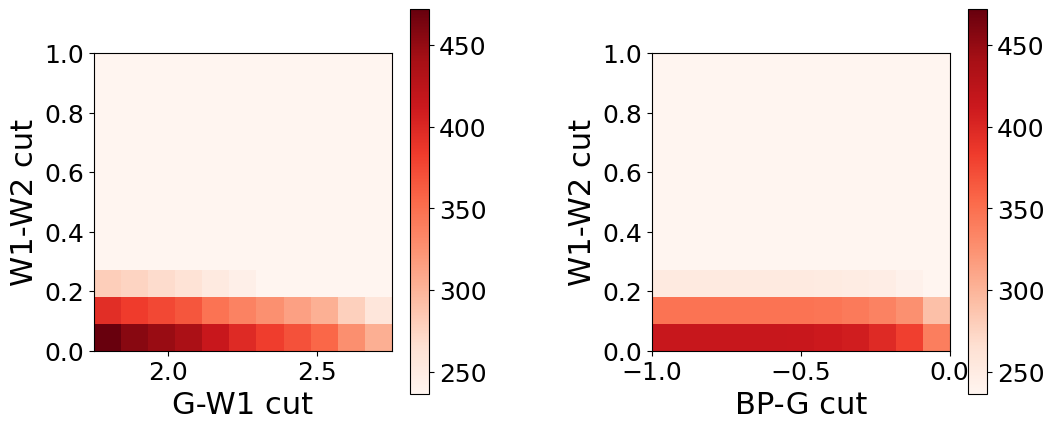

In [49]:
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)

plt.imshow(fps_s[:,:,k_best].T, cmap='Reds', origin='lower', extent=extent_left,
          vmin=0.5*np.max(fps_s), vmax=np.max(fps_s)
          )
plt.colorbar()
plt.xlabel(xlabel_left)
plt.ylabel(ylabel_left)

plt.subplot(122)
plt.imshow(fps_s[i_best,:,:], cmap='Reds', origin='lower', extent=extent_right,
          vmin=0.5*np.max(fps_s), vmax=np.max(fps_s)
          )
plt.colorbar()
plt.xlabel(xlabel_right)
plt.ylabel(ylabel_right)

Text(0, 0.5, 'W1-W2 cut')

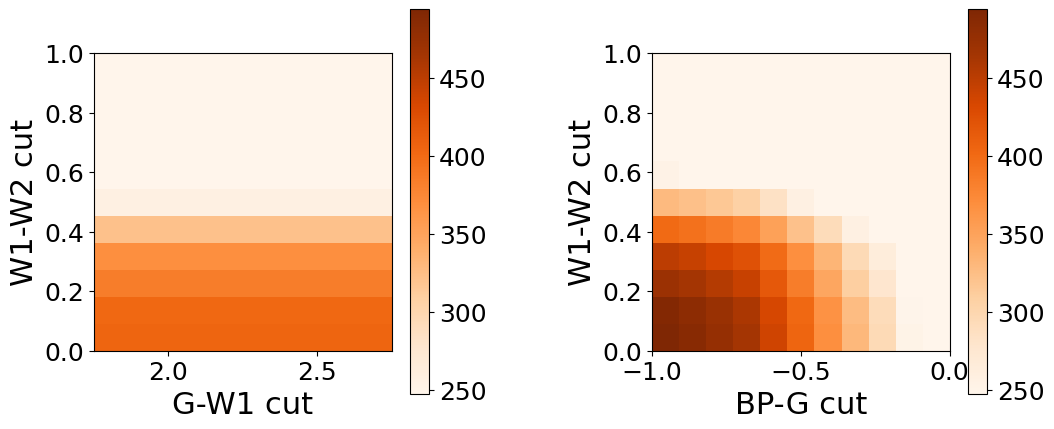

In [50]:
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)

plt.imshow(fps_g[:,:,k_best].T, cmap='Oranges', origin='lower', extent=extent_left,
          vmin=0.5*np.max(fps_g), vmax=np.max(fps_g)
          )
plt.colorbar()
plt.xlabel(xlabel_left)
plt.ylabel(ylabel_left)

plt.subplot(122)
plt.imshow(fps_g[i_best,:,:], cmap='Oranges', origin='lower', extent=extent_right,
          vmin=0.5*np.max(fps_g), vmax=np.max(fps_g)
          )
plt.colorbar()
plt.xlabel(xlabel_right)
plt.ylabel(ylabel_right)

Text(0, 0.5, 'W1-W2 cut')

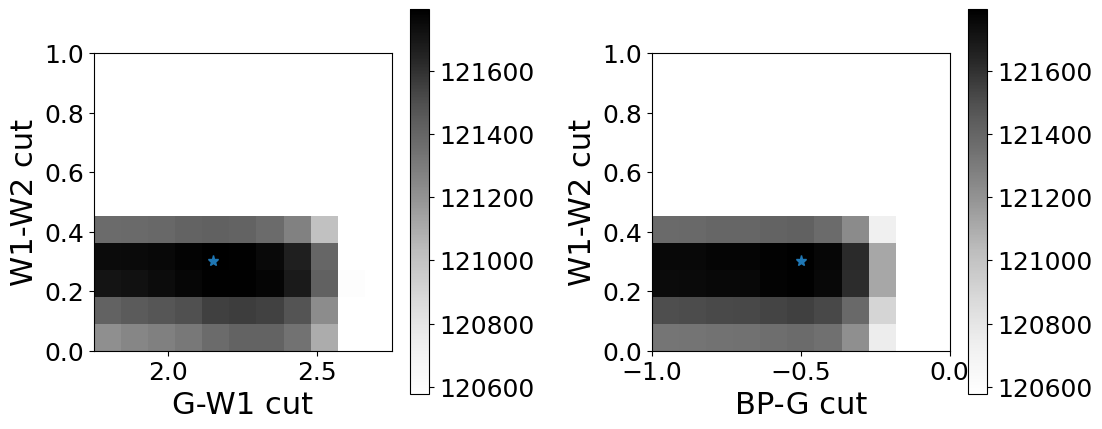

In [51]:
plt.figure(figsize=(12,5))
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)

plt.imshow(objs[:,:,k_best].T, cmap='Greys', origin='lower', extent=extent_left,
          vmin=0.99*np.max(objs), vmax=np.max(objs)
          )
plt.colorbar()
plt.plot(g_w1_vals[i_best], w1_w2_vals[j_best], marker='*', markersize=8)
plt.xlabel(xlabel_left)
plt.ylabel(ylabel_left)

plt.subplot(122)
plt.imshow(objs[i_best,:,:], cmap='Greys', origin='lower', extent=extent_right,
          vmin=0.99*np.max(objs), vmax=np.max(objs)
          )
plt.colorbar()
plt.plot(bp_g_vals[k_best], w1_w2_vals[j_best], marker='*', markersize=8)
plt.xlabel(xlabel_right)
plt.ylabel(ylabel_right)

0.11392171215820213 5.966924363647461
1.9891360931396491 7.1964803197021485


Text(0, 0.5, '$W1-W2$')

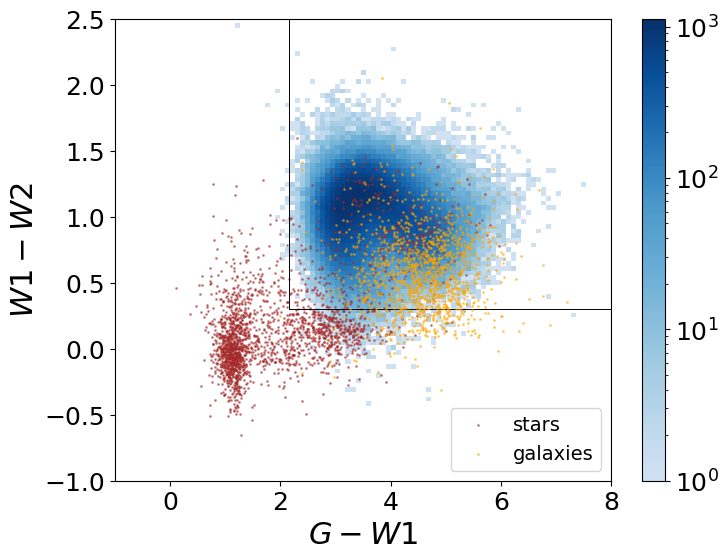

In [52]:
cut_0, cut_1 = [0, 1, w1_w2_vals[j_best]], [1, 0, g_w1_vals[i_best]]
x_eq = (cut_0[2]*cut_1[1] - cut_1[2]*cut_0[1])/(cut_0[0]*cut_1[1] - cut_1[0]*cut_0[1])
y_eq = (cut_0[2]*cut_1[0] - cut_1[2]*cut_0[0])/(cut_0[1]*cut_1[0] - cut_1[1]*cut_0[0])

fig = plt.figure(figsize=(8,6))
ax = plt.gca()
tabs = [tab_labeled_xsup[tab_labeled_xsup['class']=='q'],
        tab_labeled_xsup[tab_labeled_xsup['class']=='s'],
        tab_labeled_xsup[tab_labeled_xsup['class']=='g'],
        tab_gsup]

zorders = [1,2,3,0]

#tabs = [tab_squasars, tab_sstars, tab_sgals]
#tabs = [tab_squasars]
#zorders = [2, 1, 0]

colors = ['b', 'brown', 'orange', 'grey']
labels = ['quasars', 'stars', 'galaxies', 'gaia wnec']
ss = [0.1, 1, 1, 0.01]

# plot quasars as histogram
tab_q = tabs[0]

x_lim = (-1, 8)
y_lim = (-1, 2.5)
bins_x = np.linspace(*x_lim, 100)
bins_y = np.linspace(*y_lim, 100)

g_w1 = np.array(tab_q['phot_g_mean_mag']-tab_q['mag_w1_vg'])
w1_w2 = np.array(tab_q['mag_w1_vg']-tab_q['mag_w2_vg'])
h = ax.hist2d(g_w1, w1_w2, bins=(bins_x, bins_y), cmin=1, cmap='Blues_shifted', norm='log')
fig.colorbar(h[3])

# plot others as scatterplot
for i in range(1,len(tabs)-1):
    tab = tabs[i]
    print(np.min(tab['phot_g_mean_mag']-tab['mag_w1_vg']), np.max(tab['phot_g_mean_mag']-tab['mag_w1_vg']))
    plt.scatter(tab['phot_g_mean_mag']-tab['mag_w1_vg'], tab['mag_w1_vg']-tab['mag_w2_vg'],
                color=colors[i], label=labels[i], alpha=0.5, s=ss[i], zorder=zorders[i])

plt.legend(loc='lower right', fontsize=(14))
plt.xlim(x_lim)
plt.ylim(y_lim)

plot_cut(ax, cut_0, x_eq=x_eq, y_eq=y_eq, only_plot='above', only_axis='x')
plot_cut(ax, cut_1, x_eq=x_eq, y_eq=y_eq, only_plot='above', only_axis='y')

plt.xlabel(r'$G-W1$')
plt.ylabel(r'$W1-W2$')

Text(0, 0.5, '$G-RP$')

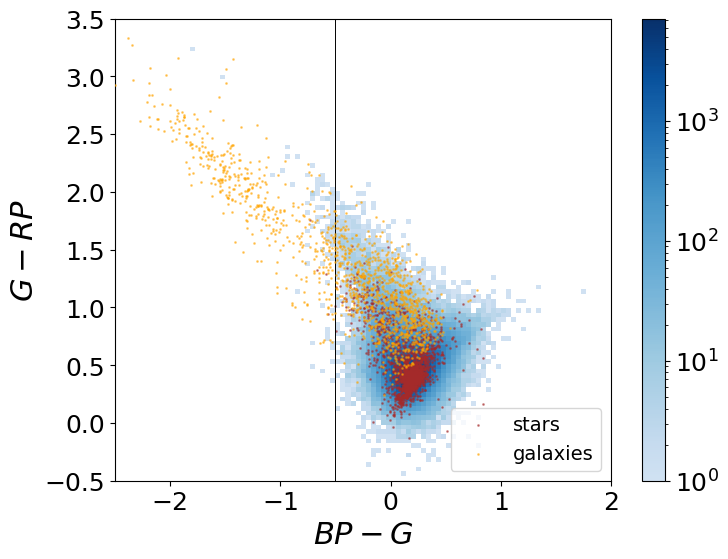

In [53]:
cut_2 = [1, 0, bp_g_vals[k_best]]

fig = plt.figure(figsize=(8,6))
ax = plt.gca()
tabs = [tab_labeled_xsup[(tab_labeled_xsup['class']=='q')],
        tab_labeled_xsup[(tab_labeled_xsup['class']=='s')],
        tab_labeled_xsup[(tab_labeled_xsup['class']=='g')],
        tab_gsup]

zorders = [1,2,3,0]

colors = ['b', 'brown', 'orange', 'grey']
labels = ['quasars', 'stars', 'galaxies', 'gaia wnec']
ss = [0.1, 1, 1, 0.01]

# plot quasars as histogram
tab_q = tabs[0]

x_lim = (-2.5, 2)
y_lim = (-0.5, 3.5)
bins_x = np.linspace(*x_lim, 100)
bins_y = np.linspace(*y_lim, 100)

h = ax.hist2d(tab_q['phot_bp_mean_mag']-tab_q['phot_g_mean_mag'],
              tab_q['phot_g_mean_mag']-tab_q['phot_rp_mean_mag'],
              bins=(bins_x, bins_y), cmin=1, cmap='Blues_shifted', norm='log')
fig.colorbar(h[3])

# plot others as scatterplot
for i in range(1,len(tabs)-1):
    tab = tabs[i]
    plt.scatter(tab['phot_bp_mean_mag']-tab['phot_g_mean_mag'], 
                tab['phot_g_mean_mag']-tab['phot_rp_mean_mag'],
                color=colors[i], label=labels[i], alpha=0.5, s=ss[i], zorder=zorders[i])

plot_cut(ax, cut_2)

plt.legend(loc='lower right', fontsize=(14))
plt.xlim(x_lim)
plt.ylim(y_lim)

plt.xlabel(r'$BP-G$')
plt.ylabel(r'$G-RP$')

Text(0, 0.5, '$G-W1$')

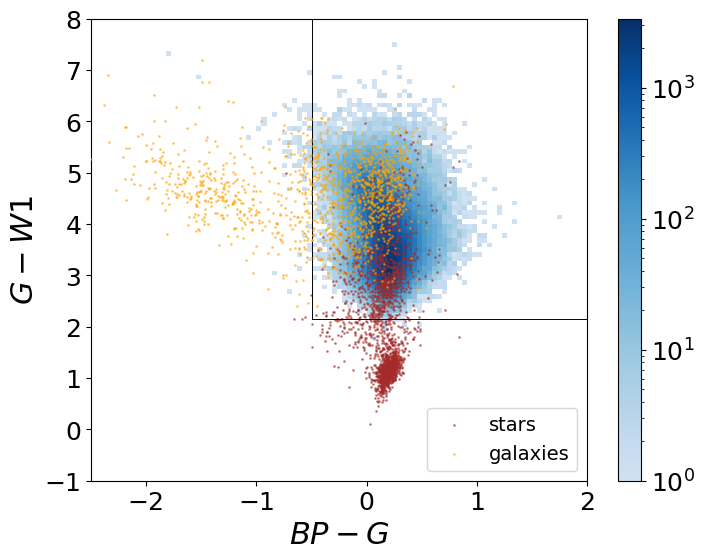

In [87]:
cut_0, cut_1 = [0, 1, g_w1_vals[i_best]], [1, 0, bp_g_vals[k_best]]
x_eq = (cut_0[2]*cut_1[1] - cut_1[2]*cut_0[1])/(cut_0[0]*cut_1[1] - cut_1[0]*cut_0[1])
y_eq = (cut_0[2]*cut_1[0] - cut_1[2]*cut_0[0])/(cut_0[1]*cut_1[0] - cut_1[1]*cut_0[0])

fig = plt.figure(figsize=(8,6))
ax = plt.gca()
tabs = [tab_labeled_xsup[(tab_labeled_xsup['class']=='q')],
        tab_labeled_xsup[(tab_labeled_xsup['class']=='s')],
        tab_labeled_xsup[(tab_labeled_xsup['class']=='g')],
        tab_gsup]

zorders = [1,2,3,0]

colors = ['b', 'brown', 'orange', 'grey']
labels = ['quasars', 'stars', 'galaxies', 'gaia wnec']
ss = [0.1, 1, 1, 0.01]

# plot quasars as histogram
tab_q = tabs[0]

x_lim = (-2.5, 2)
y_lim = (-1, 8)
bins_x = np.linspace(*x_lim, 100)
bins_y = np.linspace(*y_lim, 100)

h = ax.hist2d(tab_q['phot_bp_mean_mag']-tab_q['phot_g_mean_mag'],
              tab_q['phot_g_mean_mag']-tab_q['mag_w1_vg'],
              bins=(bins_x, bins_y), cmin=1, cmap='Blues_shifted', norm='log')
fig.colorbar(h[3])

# plot others as scatterplot
for i in range(1,len(tabs)-1):
    tab = tabs[i]
    plt.scatter(tab['phot_bp_mean_mag']-tab['phot_g_mean_mag'], 
                tab['phot_g_mean_mag']-tab['mag_w1_vg'],
                color=colors[i], label=labels[i], alpha=0.5, s=ss[i], zorder=zorders[i])
                        
plot_cut(ax, cut_0, x_eq=x_eq, y_eq=y_eq, only_plot='above', only_axis='x')
plot_cut(ax, cut_1, x_eq=x_eq, y_eq=y_eq, only_plot='above', only_axis='y')

plt.legend(loc='lower right', fontsize=(14))
# plt.xlim(x_lim)
# plt.ylim(y_lim)

plt.xlabel(r'$BP-G$')
plt.ylabel(r'$G-W1$')

Text(0, 0.5, '$W1-W2$')

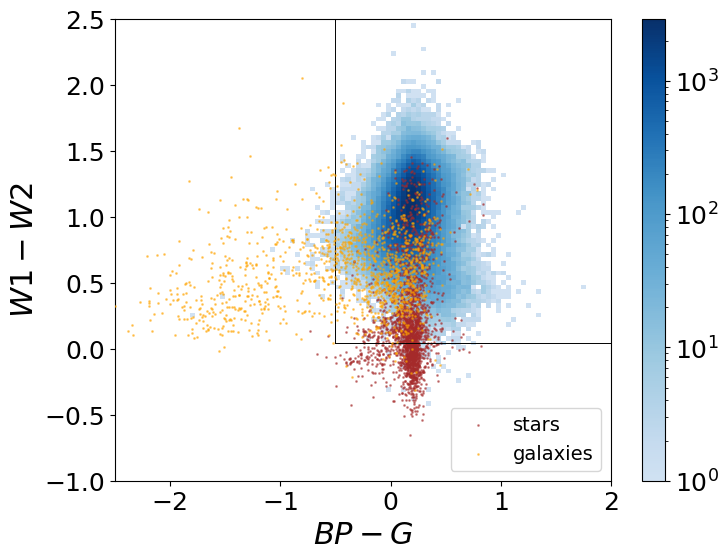

In [88]:
cut_0, cut_1 = [0, 1, w1_w2_vals[i_best]], [1, 0, bp_g_vals[k_best]]
x_eq = (cut_0[2]*cut_1[1] - cut_1[2]*cut_0[1])/(cut_0[0]*cut_1[1] - cut_1[0]*cut_0[1])
y_eq = (cut_0[2]*cut_1[0] - cut_1[2]*cut_0[0])/(cut_0[1]*cut_1[0] - cut_1[1]*cut_0[0])

fig = plt.figure(figsize=(8,6))
ax = plt.gca()
tabs = [tab_labeled_xsup[(tab_labeled_xsup['class']=='q')],
        tab_labeled_xsup[(tab_labeled_xsup['class']=='s')],
        tab_labeled_xsup[(tab_labeled_xsup['class']=='g')],
        tab_gsup]

zorders = [1,2,3,0]

colors = ['b', 'brown', 'orange', 'grey']
labels = ['quasars', 'stars', 'galaxies', 'gaia wnec']
ss = [0.1, 1, 1, 0.01]

# plot quasars as histogram
tab_q = tabs[0]

x_lim = (-2.5, 2)
y_lim = (-1, 2.5)
bins_x = np.linspace(*x_lim, 100)
bins_y = np.linspace(*y_lim, 100)

h = ax.hist2d(tab_q['phot_bp_mean_mag']-tab_q['phot_g_mean_mag'],
              tab_q['mag_w1_vg']-tab_q['mag_w2_vg'],
              bins=(bins_x, bins_y), cmin=1, cmap='Blues_shifted', norm='log')
fig.colorbar(h[3])

# plot others as scatterplot
for i in range(1,len(tabs)-1):
    tab = tabs[i]
    plt.scatter(tab['phot_bp_mean_mag']-tab['phot_g_mean_mag'], 
                tab['mag_w1_vg']-tab['mag_w2_vg'],
                color=colors[i], label=labels[i], alpha=0.5, s=ss[i], zorder=zorders[i])
                        
plot_cut(ax, cut_0, x_eq=x_eq, y_eq=y_eq, only_plot='above', only_axis='x')
plot_cut(ax, cut_1, x_eq=x_eq, y_eq=y_eq, only_plot='above', only_axis='y')

plt.legend(loc='lower right', fontsize=(14))
# plt.xlim(x_lim)
# plt.ylim(y_lim)

plt.xlabel(r'$BP-G$')
plt.ylabel(r'$W1-W2$')

In [ ]:
idx_predq = utils.gw1_w1w2_cuts_index(X_labeled[:,0], X_labeled[:,1], color_cuts)


-0.4580170000000017 3.2406609999999993
14.691206 20.599989


Text(0, 0.5, '$G$')

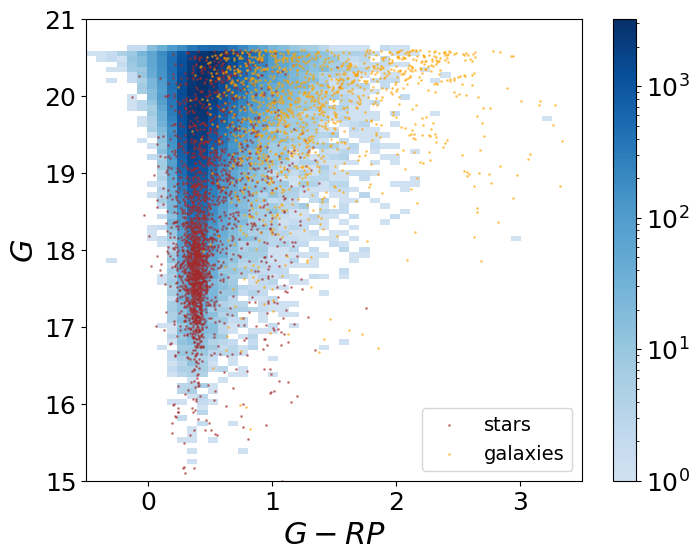

In [101]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
tabs = [tab_labeled_xsup[tab_labeled_xsup['class']=='q'],
        tab_labeled_xsup[tab_labeled_xsup['class']=='s'],
        tab_labeled_xsup[tab_labeled_xsup['class']=='g'],
        tab_gsup]

zorders = [1,2,3,0]

#tabs = [tab_squasars, tab_sstars, tab_sgals]
#tabs = [tab_squasars]
#zorders = [2, 1, 0]

colors = ['b', 'brown', 'orange', 'grey']
labels = ['quasars', 'stars', 'galaxies', 'gaia wnec']
ss = [0.1, 1, 1, 0.01]

# plot quasars as histogram
tab_q = tabs[0]

bins_x = np.linspace(-0.5, 3.5)
bins_y = np.linspace(15, 22, 100)

print(np.min(tab_q['phot_g_mean_mag']-tab_q['phot_rp_mean_mag']), np.max(tab_q['phot_g_mean_mag']-tab_q['phot_rp_mean_mag']))
print(np.min(tab_q['phot_g_mean_mag']), np.max(tab_q['phot_g_mean_mag']))
h = ax.hist2d(tab_q['phot_g_mean_mag']-tab_q['phot_rp_mean_mag'],
              tab_q['phot_g_mean_mag'],
              bins=(bins_x, bins_y), cmap='Blues_shifted', norm='log')
fig.colorbar(h[3])

# plot others as scatterplot
for i in range(1,len(tabs)-1):
    tab = tabs[i]
    plt.scatter(tab['phot_g_mean_mag']-tab['phot_rp_mean_mag'],
                tab['phot_g_mean_mag'],
                color=colors[i], label=labels[i], alpha=0.5, s=ss[i], zorder=zorders[i])

plt.legend(loc='lower right', fontsize=(14))
plt.xlim(-0.5, 3.5)
plt.ylim(15, 21)

plt.xlabel(r'$G-RP$')
plt.ylabel(r'$G$')

295227
2374
2360


Text(0, 0.5, '$G$')

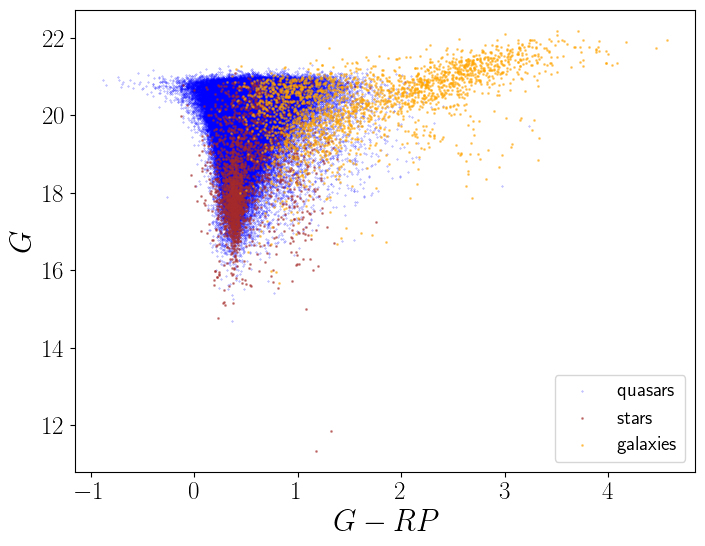

In [39]:
plt.figure(figsize=(8,6))
ax = plt.gca()
tabs = [tab_labeled[tab_labeled['class']=='q'],
        tab_labeled[tab_labeled['class']=='s'],
        tab_labeled[tab_labeled['class']=='g']]

zorders = [0,1,2]

#tabs = [tab_squasars, tab_sstars, tab_sgals]
#tabs = [tab_squasars]
#zorders = [2, 1, 0]

colors = ['b', 'brown', 'orange']
labels = ['quasars', 'stars', 'galaxies']
ss = [0.1, 1, 1]
for i, tab in enumerate(tabs):
    print(len(tab))
    plt.scatter(tab['phot_g_mean_mag']-tab['phot_rp_mean_mag'],
                tab['phot_g_mean_mag'],
                color=colors[i], label=labels[i], alpha=0.5, s=ss[i], zorder=zorders[i])

plt.legend(loc='lower right', fontsize=(14))

plt.xlabel(r'$G-RP$')
plt.ylabel(r'$G$')

# Check out clean catalog

In [11]:
fn_gaia_clean = '../data/gaia_candidates_clean.fits'
# Load data
print("Loading data")
tab_gclean = utils.load_table(fn_gaia_clean)
print('N_gaia:', len(tab_gclean))

Loading data
N_gaia: 1442077


In [12]:
G_cuts = [20.0, 20.5, 20.6]
for G_cut in G_cuts:
    i_G = tab_gclean['phot_g_mean_mag']<G_cut
    print(f'Number of objects with G<{G_cut}: {np.sum(i_G)}')

Number of objects with G<20.0: 767866
Number of objects with G<20.5: 1318566
Number of objects with G<20.6: 1442077


Text(0, 0.5, 'cumulative number')

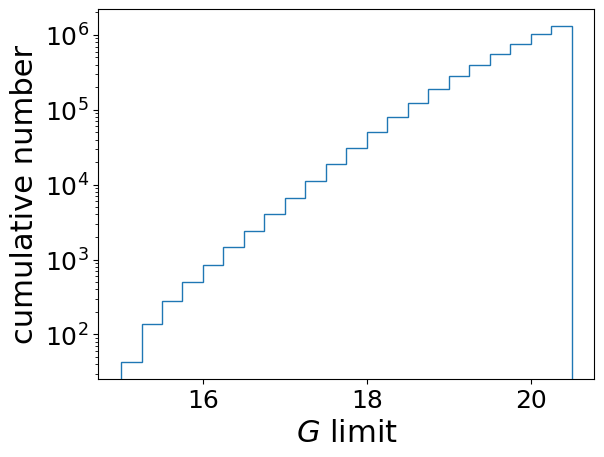

In [13]:
bin_width = 0.25
bins = np.arange(15, 20.5+bin_width, bin_width)
plt.hist(tab_gclean['phot_g_mean_mag'], bins=bins, cumulative=True, histtype='step')
plt.yscale('log')

plt.xlabel(r'$G$ limit')
plt.ylabel('cumulative number')

Text(0, 0.5, 'normalized number of objects')

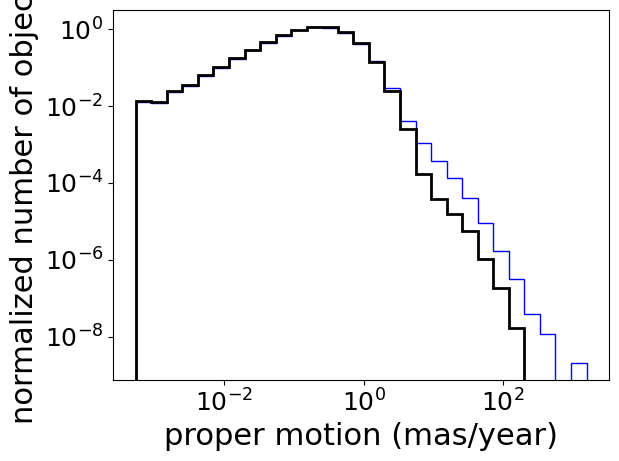

In [15]:
#bins = np.linspace(np.min(tab_gsup['pm']), np.max(tab_gsup['pm']), 30)
bins = np.logspace(np.log10(np.min(tab_gsup['pm'])), np.log10(np.max(tab_gsup['pm'])), 30)
plt.hist(tab_gsup['pm'], histtype='step', bins=bins, density=True, color='blue')
plt.hist(tab_gclean['pm'], histtype='step', bins=bins, density=True, color='k', lw=2)
plt.xscale('log')
plt.yscale('log')

plt.xlabel('proper motion (mas/year)')
plt.ylabel('normalized number of objects')

Text(0, 0.5, 'normalized number of objects')

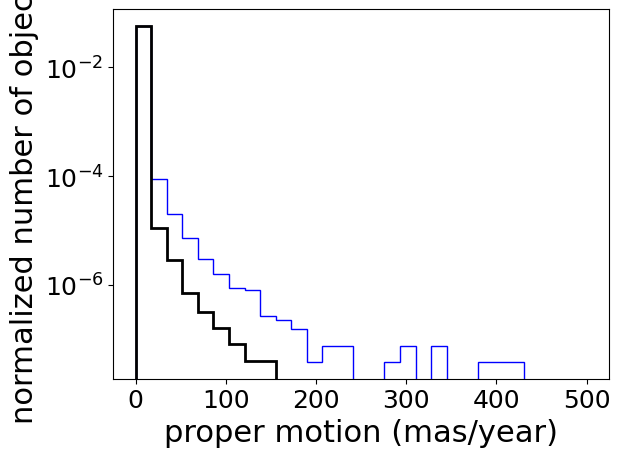

In [21]:
bins = np.linspace(0, 500, 30)
#bins = np.logspace(np.log10(np.min(tab_gsup['pm'])), np.log10(np.max(tab_gsup['pm'])), 30)
plt.hist(tab_gsup['pm'], histtype='step', bins=bins, density=True, color='blue')
plt.hist(tab_gclean['pm'], histtype='step', bins=bins, density=True, color='k', lw=2)
plt.yscale('log')

plt.xlabel('proper motion (mas/year)')
plt.ylabel('normalized number of objects')

In [45]:
print(np.sum(tab_gsup['pm'] > 10), np.sum(tab_gclean['pm'] > 10))
print(np.sum(tab_gsup['pm'] > 5), np.sum(tab_gclean['pm'] > 5))
print(np.sum(tab_gsup['pm'] > 3), np.sum(tab_gclean['pm'] > 3))
print(np.sum(tab_gsup['pm'] > 1), np.sum(tab_gclean['pm'] > 1))


6743 716
15143 2245
33001 14289
353850 304182


In [59]:
tab_gsup.columns

<TableColumns names=('source_id','ra','dec','l','b','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_g_n_obs','phot_bp_n_obs','phot_rp_n_obs','redshift_qsoc','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','pmra','pmra_error','pmdec','pmdec_error','parallax','parallax_error','ebv','A_v','pm','rand_ints','mag_w1_vg','mag_w2_vg','unwise_objid','g_rp','bp_g','bp_rp','g_w1','w1_w2')>

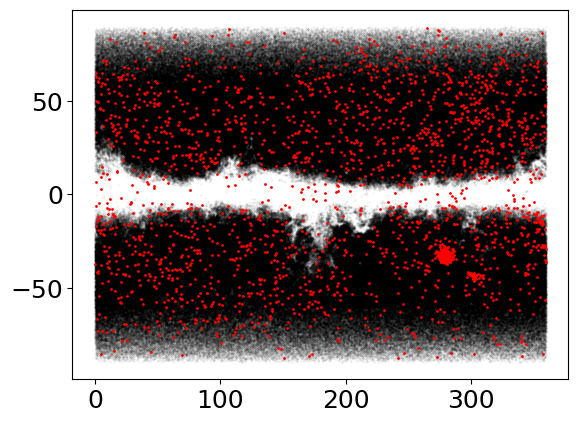

In [63]:
i_bigpm = tab_gclean['pm'] > 5
plt.scatter(tab_gclean['l'], tab_gclean['b'], color='k', s=0.1, alpha=0.1)
plt.scatter(tab_gclean['l'][i_bigpm], tab_gclean['b'][i_bigpm], color='red', s=1)

Text(0, 0.5, '$W1-W2$')

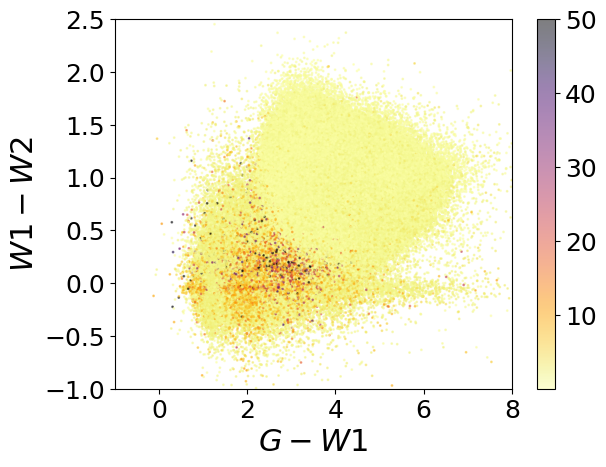

In [29]:
plt.scatter(tab_gsup['g_w1'], tab_gsup['w1_w2'], s=1, alpha=0.5, c=tab_gsup['pm'], vmax=50, cmap='inferno_r')
plt.colorbar()

x_lim = (-1, 8)
y_lim = (-1, 2.5)
plt.xlim(x_lim)
plt.ylim(y_lim)

plt.xlabel(r'$G-W1$')
plt.ylabel(r'$W1-W2$')

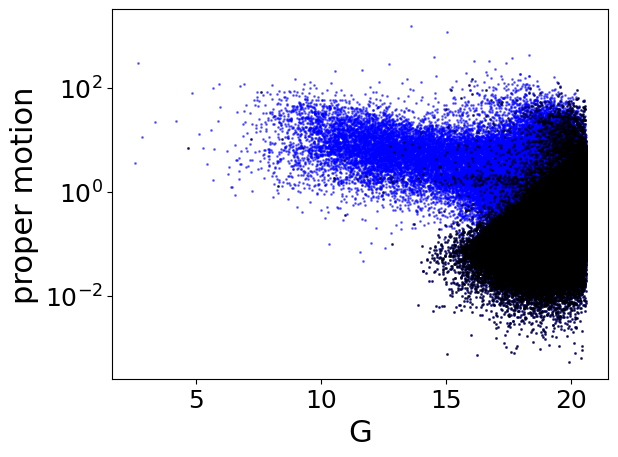

In [52]:
plt.scatter(tab_gsup['phot_g_mean_mag'], tab_gsup['pm'], s=1, alpha=0.5, c='b')
plt.scatter(tab_gclean['phot_g_mean_mag'], tab_gclean['pm'], s=1, alpha=0.5, c='k')
#plt.ylim(0,100)
plt.xlabel('G')
plt.ylabel('proper motion')
plt.yscale('log')

function of G that predicts mean squared proper motion of quasars.

In [53]:
pm_error_gsup = np.sqrt(tab_gsup['pmra_error']**2 + 
                   tab_gsup['pmdec_error']**2)

(0.0, 100.0)

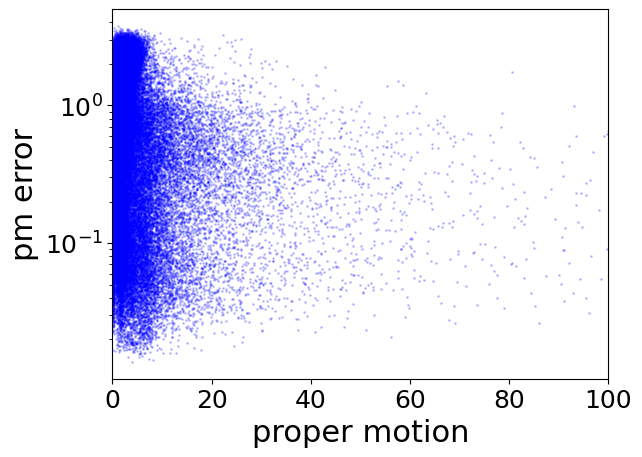

In [58]:
plt.scatter(tab_gsup['pm'], pm_error_gsup, s=1, alpha=0.2, c='b')
#plt.ylim(0,100)
plt.ylabel('pm error')
plt.xlabel('proper motion')
plt.yscale('log')
plt.xlim(0, 100)


In [90]:
def _pm_G_line(G):
    return 10**(0.4*(G-18.25))

def cut_pm_G(tab):
    i_makescut = tab['pm'] < _pm_G_line(tab['phot_g_mean_mag'])
    return i_makescut

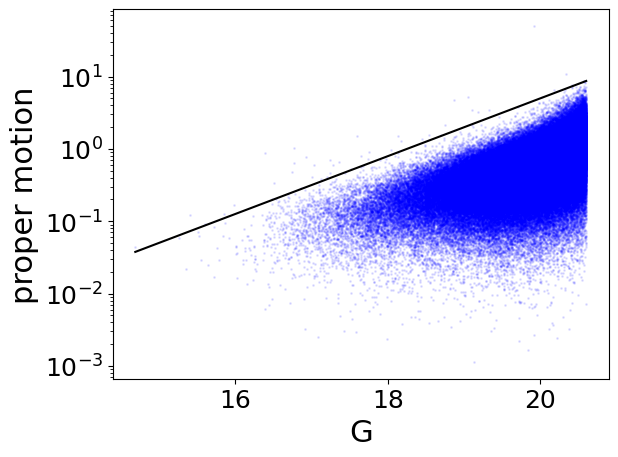

In [91]:
xx = np.linspace(np.min(tab_q['phot_g_mean_mag']), np.max(tab_q['phot_g_mean_mag']), 10)
yy = _pm_G_line(xx)

plt.scatter(tab_q['phot_g_mean_mag'], tab_q['pm'], s=1, alpha=0.1, c='b')

plt.plot(xx, yy, color='k')

#plt.ylim(0,100)
plt.xlabel('G')
plt.ylabel('proper motion')
plt.yscale('log')

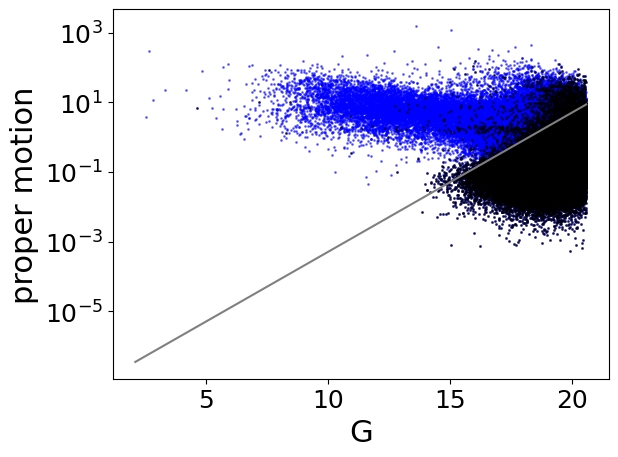

In [92]:
xx = np.linspace(np.min(tab_gsup['phot_g_mean_mag']), np.max(tab_gsup['phot_g_mean_mag']), 10)
yy = _pm_G_line(xx)

plt.plot(xx, yy, color='grey')


plt.scatter(tab_gsup['phot_g_mean_mag'], tab_gsup['pm'], s=1, alpha=0.5, c='b')
plt.scatter(tab_gclean['phot_g_mean_mag'], tab_gclean['pm'], s=1, alpha=0.5, c='k')
#plt.ylim(0,100)
plt.xlabel('G')
plt.ylabel('proper motion')
plt.yscale('log')

In [93]:
i_pmcut = cut_pm_G(tab_gclean)
print(np.sum(i_pmcut)/len(i_pmcut))
print(np.sum(~i_pmcut))

0.9963663521434708
2477


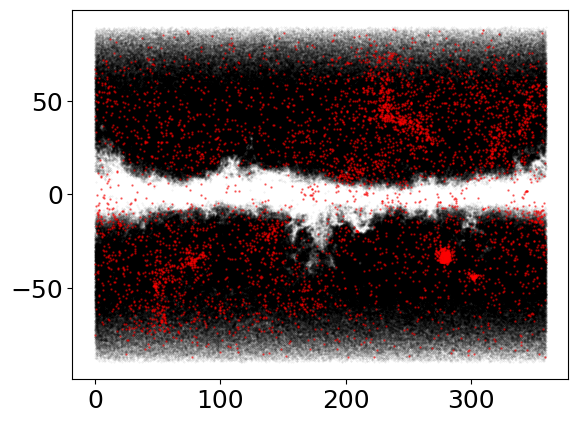

In [95]:
plt.scatter(tab_gclean['l'], tab_gclean['b'], color='k', s=0.1, alpha=0.1)
plt.scatter(tab_gclean['l'][~i_pmcut], tab_gclean['b'][~i_pmcut], color='red', s=0.5, alpha=0.5)

In [97]:
def get_ndens_map(ras, decs, NSIDE=64):
    map_nqso, _ = maps.get_map(NSIDE, ras, decs, null_val=0)
    map_ndens = map_nqso/area_per_pixel
    map_ndens_masked = hp.ma(map_ndens)
    map_ndens_masked.mask = map_ndens==0
    return map_ndens_masked

In [99]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


In [112]:
i_Ghi = tab_gclean['phot_g_mean_mag'] < 20.5

map_clean_pmcut = get_ndens_map(tab_gclean['ra'][i_pmcut & i_Ghi], tab_gclean['dec'][i_pmcut & i_Ghi])

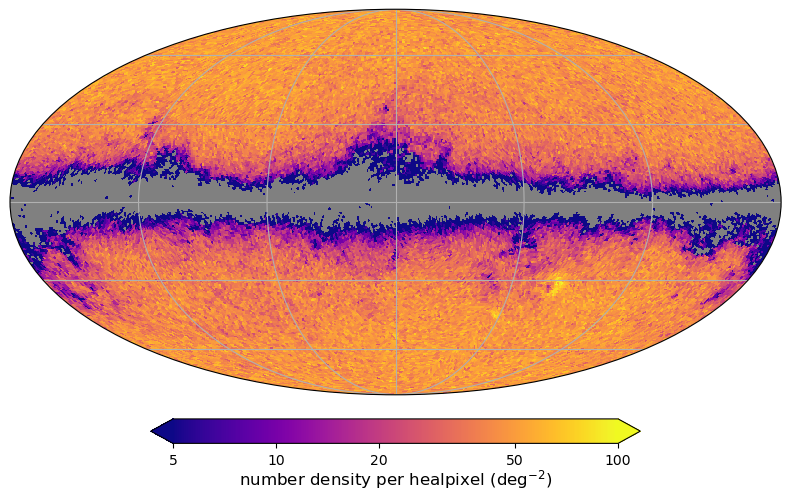

In [113]:
projview(map_clean_pmcut, title='',
            unit=r"number density per healpixel (deg$^{-2}$)", cmap='plasma', coord=['C', 'G'], 
            min=5, max=100, norm='log', graticule=True,
            cbar_ticks=[5, 10, 20, 50, 100])